In [1]:
import os
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torch.utils.data import Dataset, DataLoader

import numpy as np
from PIL import Image

In [2]:
seed = 1

lr = 0.0001
momentum = 0.2

batch_size = 32
test_batch_size = 32

epochs = 100
no_cuda = False
log_interval = 100

# Model

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Preprocess

In [4]:
train_paths = glob('../dataset/mnist_png/training/*/*.png')[:1000]
test_paths = glob('../dataset/mnist_png/testing/*/*.png')[:1000]

len(train_paths), len(test_paths)

(1000, 1000)

참고: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class

In [5]:
class Dataset(Dataset):
    def __init__(self, data_paths, transform=None):

        self.data_paths = data_paths
        self.transform = transform

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        path = self.data_paths[idx]
        image = Image.open(path).convert("L")
        label = int(path.split('\\')[-2])
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
torch.manual_seed(seed)

use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    Dataset(train_paths, 
            transforms.Compose([
                transforms.RandomHorizontalFlip(), 
                transforms.ToTensor(), 
                transforms.Normalize(
                    mean=[0.406], 
                    std=[0.225])])
           ),
    batch_size=batch_size, 
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    Dataset(test_paths,
           transforms.Compose([
               transforms.ToTensor(), 
               transforms.Normalize(
                   mean=[0.406], 
                   std=[0.225])])
           ),
    batch_size=batch_size, 
    shuffle=False
)

# Optimization

In [7]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Training

In [8]:
import torchvision
from torch.utils.tensorboard import SummaryWriter

In [9]:
writer = SummaryWriter()

In [11]:
for epoch in range(1, epochs + 1):
    # Train Mode
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)  # https://pytorch.org/docs/stable/nn.html#nll-loss
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    # Test mode
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))
    
    grid = torchvision.utils.make_grid(data)
    writer.add_image("images", grid, epoch)
    writer.add_graph(model, data)
    
    writer.add_scalar("loss/train/", loss, epoch)
    writer.add_scalar('loss/test/', test_loss, epoch)
    writer.add_scalar('accuracy/test/', accuracy, epoch)

Train Epoch: 1 [0/1000 (0%)]	Loss: 2.051063

Test set: Average loss: 1.8168, Accuracy: 980/1000 (98%)

Train Epoch: 2 [0/1000 (0%)]	Loss: 1.819814

Test set: Average loss: 1.5995, Accuracy: 980/1000 (98%)

Train Epoch: 3 [0/1000 (0%)]	Loss: 1.610280

Test set: Average loss: 1.3730, Accuracy: 980/1000 (98%)

Train Epoch: 4 [0/1000 (0%)]	Loss: 1.345911

Test set: Average loss: 1.1424, Accuracy: 980/1000 (98%)

Train Epoch: 5 [0/1000 (0%)]	Loss: 1.152831

Test set: Average loss: 0.9206, Accuracy: 980/1000 (98%)

Train Epoch: 6 [0/1000 (0%)]	Loss: 0.910404

Test set: Average loss: 0.7237, Accuracy: 980/1000 (98%)

Train Epoch: 7 [0/1000 (0%)]	Loss: 0.682753

Test set: Average loss: 0.5634, Accuracy: 980/1000 (98%)

Train Epoch: 8 [0/1000 (0%)]	Loss: 0.512180

Test set: Average loss: 0.4421, Accuracy: 980/1000 (98%)

Train Epoch: 9 [0/1000 (0%)]	Loss: 0.412357

Test set: Average loss: 0.3546, Accuracy: 980/1000 (98%)

Train Epoch: 10 [0/1000 (0%)]	Loss: 0.307327

Test set: Average loss: 0.2

Train Epoch: 80 [0/1000 (0%)]	Loss: 0.005729

Test set: Average loss: 0.1186, Accuracy: 980/1000 (98%)

Train Epoch: 81 [0/1000 (0%)]	Loss: 0.005365

Test set: Average loss: 0.1188, Accuracy: 980/1000 (98%)

Train Epoch: 82 [0/1000 (0%)]	Loss: 0.005862

Test set: Average loss: 0.1190, Accuracy: 980/1000 (98%)

Train Epoch: 83 [0/1000 (0%)]	Loss: 0.005452

Test set: Average loss: 0.1191, Accuracy: 980/1000 (98%)

Train Epoch: 84 [0/1000 (0%)]	Loss: 0.005895

Test set: Average loss: 0.1193, Accuracy: 980/1000 (98%)

Train Epoch: 85 [0/1000 (0%)]	Loss: 0.004838

Test set: Average loss: 0.1195, Accuracy: 980/1000 (98%)

Train Epoch: 86 [0/1000 (0%)]	Loss: 0.004744

Test set: Average loss: 0.1197, Accuracy: 980/1000 (98%)

Train Epoch: 87 [0/1000 (0%)]	Loss: 0.005337

Test set: Average loss: 0.1199, Accuracy: 980/1000 (98%)

Train Epoch: 88 [0/1000 (0%)]	Loss: 0.004556

Test set: Average loss: 0.1201, Accuracy: 980/1000 (98%)

Train Epoch: 89 [0/1000 (0%)]	Loss: 0.003940

Test set: Average 

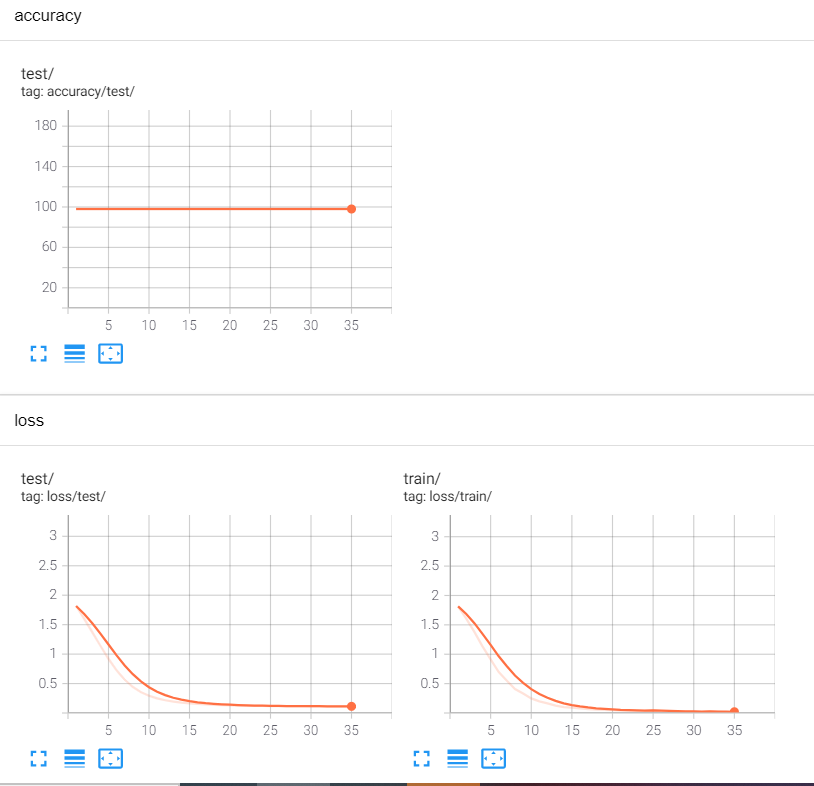

In [14]:
from IPython.display import Image

Image('G:/내 드라이브/패스트캠퍼스/Part3)/4.PNG')

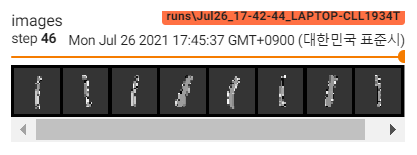

In [15]:
Image('G:/내 드라이브/패스트캠퍼스/Part3)/5.PNG')

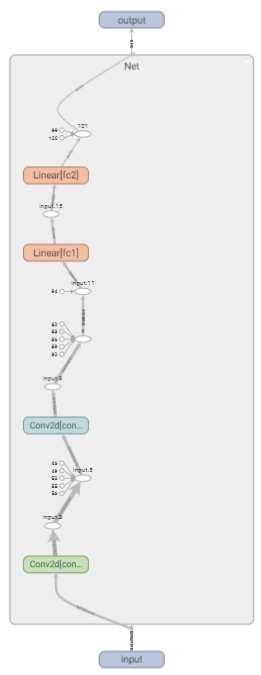

In [16]:
Image('G:/내 드라이브/패스트캠퍼스/Part3)/6.PNG')